In [531]:
from astroML.time_series import generate_damped_RW 

Parameter [lower bound, upper bound]
log(M/M⊙) [6.5, 9.5]
log(L/Ledd) [-2, 0]
z [0.1, 2.5]
amplitude (mag) [0.0, 1.0]
period (days) [360, 1080]
sawtoothiness (%) [0.0, 1.0 ]
phase [0.0, 2π]


In [533]:
def generateFixedSample():
    amplitude = 0.5
    tau = 1000
    t_rest = list(range(1,3650)) # days for 10 yrs
    redshift = 1
    period = 3*365
    drw = generate_damped_RW(t_rest, tau, redshift)
    sine = [ amplitude * math.sin(2 * math.pi * (x % period) / period) for x in t_rest ]
    drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  
    return (t_rest, drw_sine, drw, sine)

In [534]:
import random
import numpy as np

def generateRandomSample(survey_params, is_binary):
    # tau parameter for damped random walk
    tau = random.uniform(survey_params.observation_period/1000, 15*survey_params.observation_period)
    print("DRW tau=" + str(tau))

    # redshift between 0.1 to 2.5
    redshift = random.uniform(0.1, 2.5)
    print("redshift=" + str(redshift))

    sine = []

    # Observations have certain cadence. e.g. expected to be every ~7 days for LSST. Therefore,
    t_rest = list(range(1, survey_params.observation_period, survey_params.cadence))
    # 7 days cadence is not exact, so add Gaussian noise with sigma = 1 day (for LSST) to the observation days
    t_rest = [ x + random.gauss(0, survey_params.cadence_deviation) for x in t_rest ]

    # Generate the damped random walk signal
    drw = generate_damped_RW(t_rest, tau, redshift, SFinf = 0.5)

    # Sum the DRW and sinusoidal signals
    if is_binary:
        # amplitude of sinusoidal signal
        amplitude = random.uniform(0.05, 0.5) 
        print("sinusoidal signal amplitude=" + str(amplitude))
    
        # period of binary between 30 days to 10 yrs
        period = random.uniform(30, survey_params.observation_period)
        print("sinusoidal signal period=" + str(period))

        # Generate sinusoidal signal for binary
        phase = random.uniform(0, 1)
        print("sinusoidal signal phase=" + str(phase) +" * 2 * pi")

        sine = [ amplitude * math.sin(2 * math.pi * (phase + (x % period) / period)) for x in t_rest ]
        drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  
    else:
        drw_sine = drw
        
    # Add gaussian noise to simulate photometric error
    drw_sine = [ x + random.gauss(0, survey_params.photometric_error) for x in drw_sine ]

    # wipe off about 6 months signal every year due to simulate gaps in observation
    drw_sine_with_gaps = []
    t_rest_with_gaps = []
    gap_start = random.uniform(1,  365 - survey_params.gap_period)
    gap_end = gap_start + survey_params.gap_period
    for x in range(0, len(t_rest)):
        if ((t_rest[x] % 365) < gap_start or (t_rest[x] % 365) >= gap_end):
            drw_sine_with_gaps.append(drw_sine[x])
            t_rest_with_gaps.append(t_rest[x])
    print("total num observations=" + str(len(t_rest_with_gaps)))
    # add simulated error bars
    signal_error = [ abs(random.gauss(0, 0.1)) for x in t_rest_with_gaps ]
    return (t_rest_with_gaps, drw_sine_with_gaps, signal_error, t_rest, drw, sine)

In [535]:
from dataclasses import dataclass
@dataclass(frozen=True)
class SurveyParams:
    observation_period: float
    cadence: float
    cadence_deviation: float
    photometric_error: float
    gap_period: float

# Parameters for different surveys, to be confirmed
LSST = SurveyParams(observation_period = 10 * 365, cadence = 7, cadence_deviation = 1, photometric_error = 0.01, gap_period = 182)
CRTS = SurveyParams(observation_period = 7 * 365, cadence = 20, cadence_deviation = 3, photometric_error = 0.1, gap_period = 200)
IMLT = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182) 
AXIS = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)

DRW tau=11832.916117921506
redshift=2.32457753115288
sinusoidal signal amplitude=0.16701960220185358
sinusoidal signal period=1612.5629286283558
sinusoidal signal phase=0.019907564576964853 * 2 * pi
total num observations=259


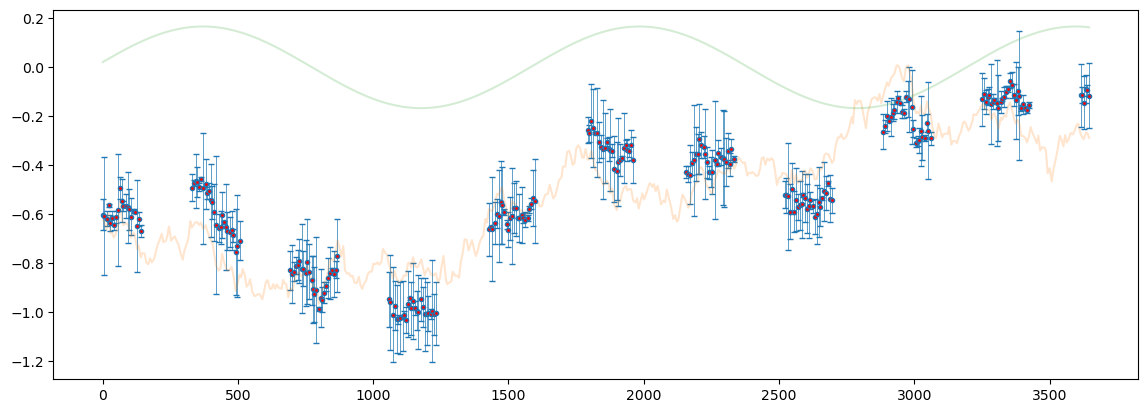

In [536]:
# main function
import matplotlib.pyplot as plt
import math

is_binary = True
light_curve = generateRandomSample(LSST, is_binary) #  generateFixedSample / generateRandomSample(LSST) 
plt.figure().set_figwidth(14)
plt.errorbar(light_curve[0], light_curve[1], yerr=light_curve[2], fmt='o', ms=3, mfc='red', lw=0.5,capsize=2, mouseover=True)
plt.plot(light_curve[3], light_curve[4], alpha=0.2)
if is_binary:
    plt.plot(light_curve[3], light_curve[5], alpha=0.2)

plt.show()